# Summery of project
This notebook contains a summary of what we have made throughout the project. The notebook has the following structure.

1. Data loading and preprocessing \
This section shows the data and some preprocessing that was made.


2. Gaussian filter and pretrained YOLO3 \
This section is about how gaussian filteres and a pretrained YOLO3 model was used to identify relevant images that should be labelled.


3. Results of the models \
In this section the the baseline results of the models are shown. The transfer learned YOLO3 is performing great already here.  


4. Improvements of models \
This section describes the improvements that was made to the models and the new results.   

#### Importation of packages
This code snippet contains the packages that are imported to make a clean summery of what has been done in the project.

In [3]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, "/Users/oskarlassen/Desktop/DeepLearning/Project/Deep-Learning-Project/")
sys.path.insert(1, "/Users/oskarlassen/Desktop/DeepLearning/Project/Deep-Learning-Project/Random")

# YOLO3 Lib
from model import predict_YOLO, predict_YOLO3_cphdata, predict_print_YOLO3_cphdata
from yolo3_one_file_to_detect_them_all import * 

# Own library
from CopActNet.tools import reader, writer, visualizer
from CopActNet import config as cfg
from CopActNet.preprocessing import diff_image

# Standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Keras packs
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D
from keras.layers.merge import add, concatenate
from keras.models import Model,load_model
from keras.preprocessing.image import load_img,img_to_array
from keras.backend import expand_dims

# Sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Tensorflow
import tensorflow as tf

# Other packs
import struct
from pathlib import Path
from PIL import Image
from os import listdir
from os.path import isfile, join

## 1. The Copenhagen Video Data
Here the reader will briefly be introduced to the data and get insights in how the many functions in our backend helps us easily navigate in the data. 

#### 1.1 Video loader
A function called "load_video" has been made which takes the video file as input and returns a tensor that holds the video. 
The video goes through a number of preprocessing steps which includes.

    1) Rescaling to 128x128.
    2) Rotating the frames 90 degrees
    2) Cutting the upper 1/4 of the image
    3) Skipping every 3rd frame in the video
    
The package is made in a way such that all parameters can be changed in the config file. 

In [4]:
video_frames = reader.load_video("data/BikeVideo/Video/FILE0004.MP4")

100%|██████████| 14400/14400 [08:19<00:00, 28.84it/s]


The video has now been made into a tensor with 14400 frames of pictures of size 128x128 with 3 colors.

In [5]:
video_frames.shape

(14400, 128, 128, 3)

#### 1.2 Pickle writer
In order not to have to load the video-data every time a write function has been made that takes the tensor and saves it as a pickle file.

In [6]:
writer.pickle_obj("data/File0004.pkl",video_frames)

#### 1.3 Pickle reader
We when read the pickle file again. 

In [7]:
video_frames = reader.load_pickle("data/File0004.pkl")

In [8]:
video_frames.shape

(14400, 128, 128, 3)

#### 1.4 Visualizing some frames
A function called visualizer can be found in our visualization library. We print a couple of random frames below. 

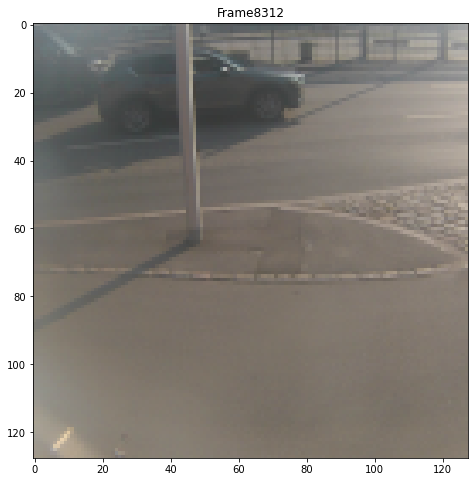

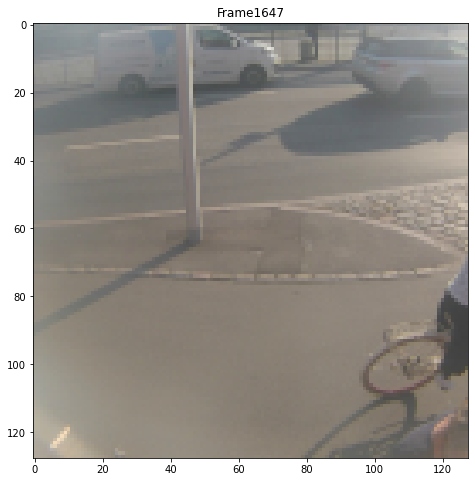

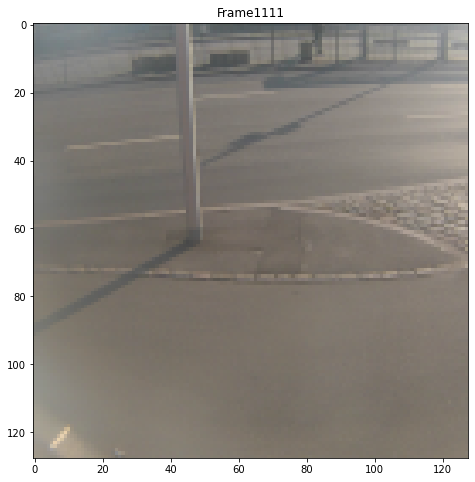

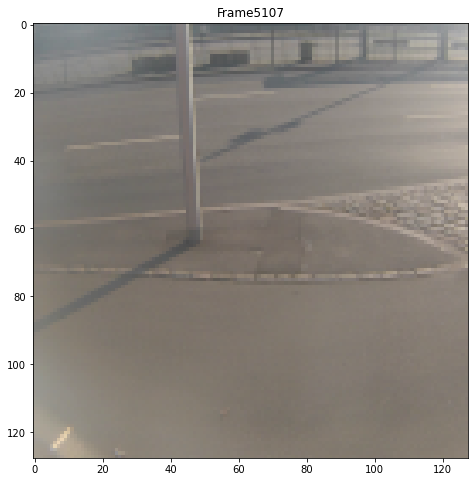

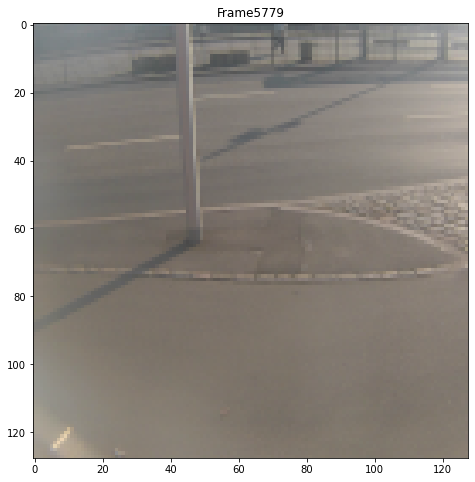

In [9]:
for i in (np.random.random(5)*10000):
    visualizer.showFrameNumpy(video_frames[int(i)], title = "Frame{}".format(int(i)))

## 2. Pretrained YOLO3 and gaussian filter and smart selection of frames for annotation
This section is about how a YOLO3 infrastructure was implemented with pretrained weights and the Copenhagen Bicycle data was tested on the model. \
Based on the findings we decided to include the pretrained model in the choice of which frames that should be annotated. This saved us alot of time as we had about 1 million frames in total of which only about 5\% had bicycles. 

We have used the following GitHub https://github.com/experiencor/keras-yolo3 to find the pretrained model. In extend, the following guide has been used https://machinelearningmastery.com/how-to-perform-object-detection-with-yolov3-in-keras/.

A couple of steps the includes how to download weights and create a model will be made below. However, for now we just load the model to get started. 

In [10]:
# load yolov3 model
model = load_model('data/model.h5')

### 2.1 Example of YOLO3 with pretrained weights
A function that predicts bounding boxes and makes a classification for each bounding box is made below. In extend it is visualized. \
It seems that the pretrained model is actually already now able to both detect the bikes as well as persons for some frames. However, it has some issues. 

person
motorbike


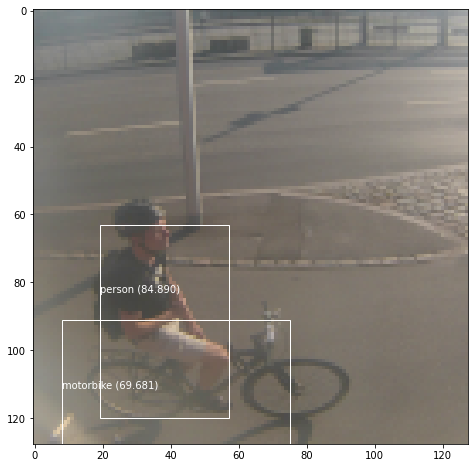

person


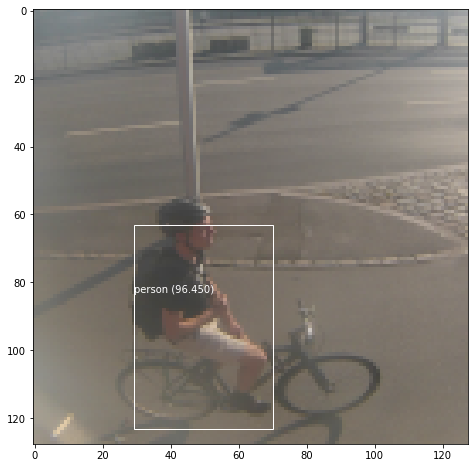

person
bicycle


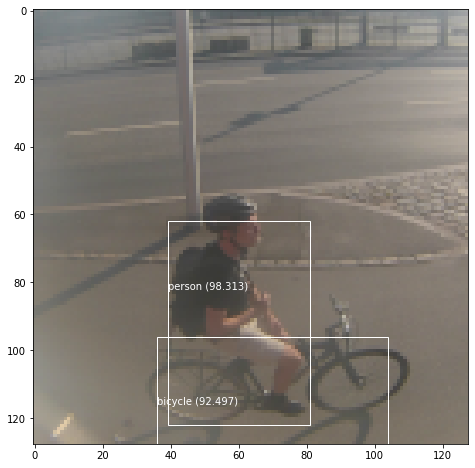

['person', 'bicycle']

In [11]:
####### RETURN ########
predict_print_YOLO3_cphdata(video_frames[9377], model)
predict_print_YOLO3_cphdata(video_frames[9378], model)
predict_print_YOLO3_cphdata(video_frames[9379], model)

Here we can write some clever text.

### 2.2 Smart way of annotating frames
To make a YOLO3 model that is optimized for our cause we must label some of the frames. As there is about 14400 frames per 10 minutes video (even though we only consider every 3rd frame) we want to find a clever way of chosing the frames that we want to annotate. 

Especially, we want to annotate the frames where there are activity. Our approach for doing to is the following:

    1) Consider the absolute value of the frame difference for each frame in the video.
        i) Apply two gaussian filters on the frame difference with different variance.
        ii) Select the frames where the gaussian filter with high variance is above the gaussian filter with low variance. 
        
These frames should represent a coarse sorting of which frames that has activity. In the below a function that considers the frame difference is showed.

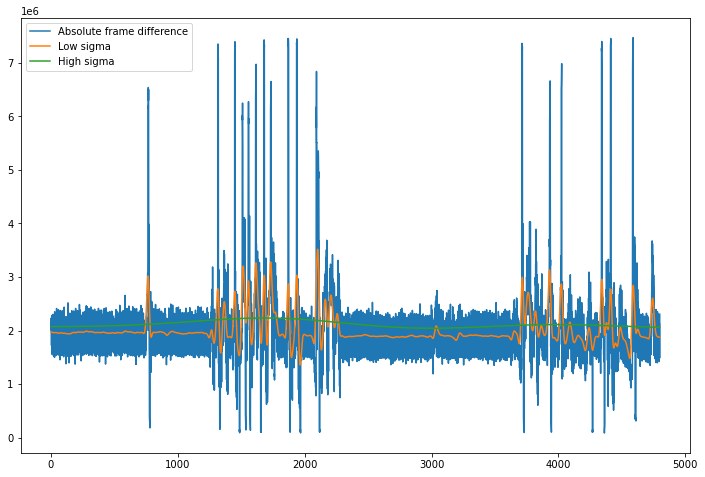

In [12]:
diff_image.diff_image_plot(video_frames)

Now we want to choose the frames with high activity. Thus, the frames where the low sigma gaussian filter is higher than the high sigma is selected. 

In [13]:
active_frame = diff_image.diff_image(video_frames)

#### Visualisation of frames with activity
Below the visualizer function is used to show the frames that the gaussian filter returns.

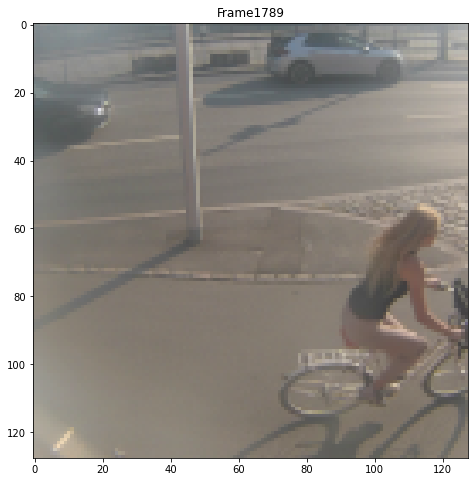

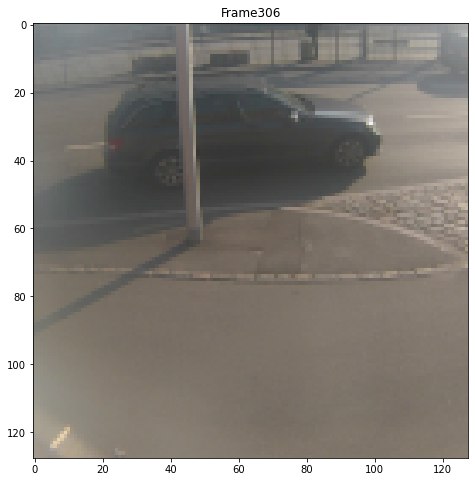

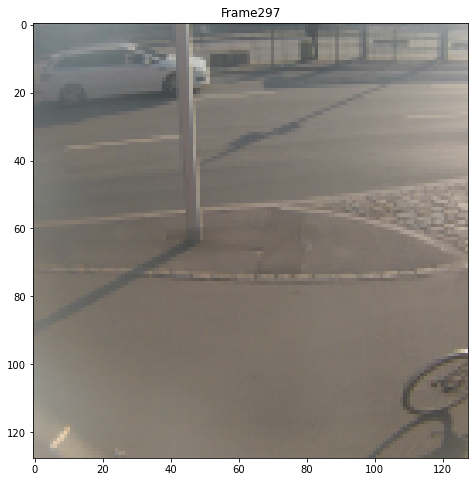

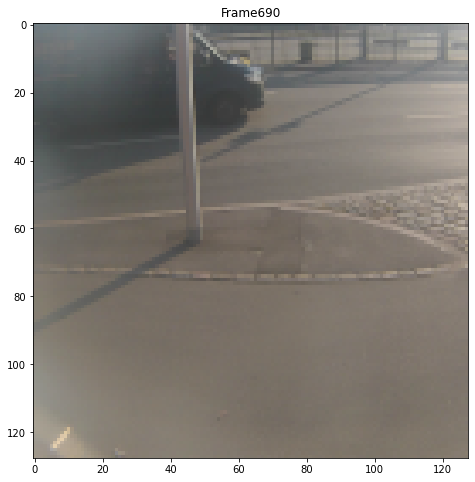

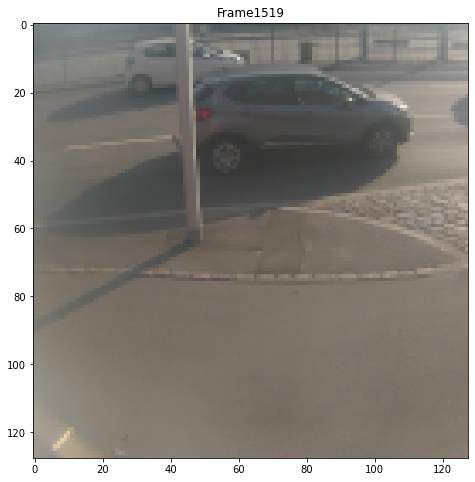

In [14]:
for i in (np.random.random(5)*active_frame.shape[0]):
    visualizer.showFrameNumpy(active_frame[int(i)], title = "Frame{}".format(int(i)))

We clearly see that these frames in general have more activity. However, there is still more than 2000 frames and we are specifically interested in annotating the frames with cyclists in. Therefore, the following is done. 

### 2.3 Using YOLO3 to select relevant frames for annotation
The frames left after the gaussian filter was applied are put into the pretrained YOLO3 and returns a prediction of bikes. The logic is, that if the model predicts a bike it is likely that a bike is on the picture. The data predicted by YOLO3 is manually labelled afterwards, but we use the gaussian filter and the model to provide the interesting frames. \
The bounding box output of the YOLO3 model is converted into a binary variable [0,1] that is 0 if there are no bikes or persons predicted in the frame and 1 if there are either bikes of persons in the frame.

In [15]:
# load yolov3 model
model = load_model('data/model.h5')

annotate_index = []
i = 0
for img in active_frame:
    ####### RETURN ########
    labels = predict_YOLO3_cphdata(img, model)
    if ("bicycle" in labels) or ("person" in labels):
        annotate_index.append(1)
    else:
        annotate_index.append(0)
    
    if i % 200 == 0:
#        print(i)
    i +=1

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200


In [16]:
pkl_annotation = reader.load_pickle("/Users/oskarlassen/Desktop/DeepLearning/Project/Deep-Learning-Project/Annotations/Frames_forannotation.pkl")
pkl_annotation.shape

(330, 128, 128, 3)

Now let us visualize the frames that we have chosen for annotation.

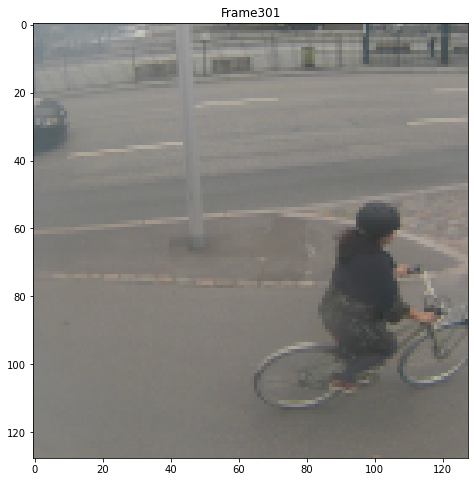

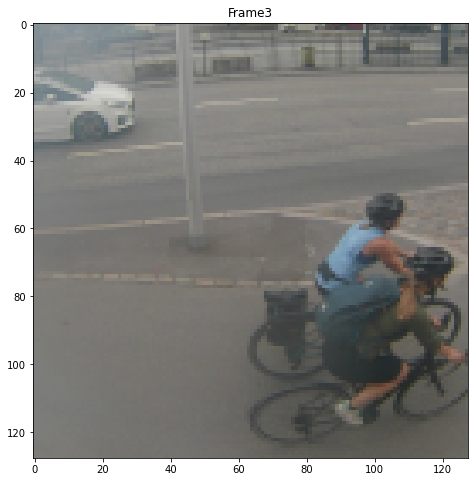

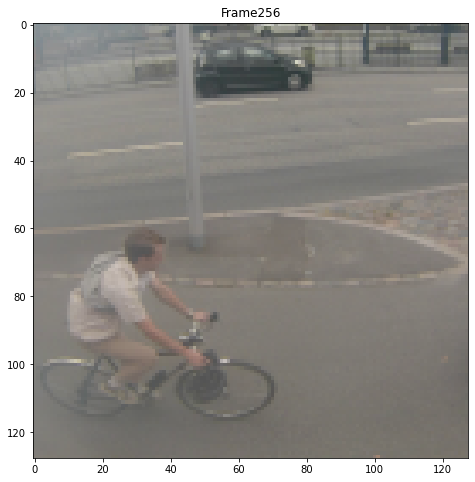

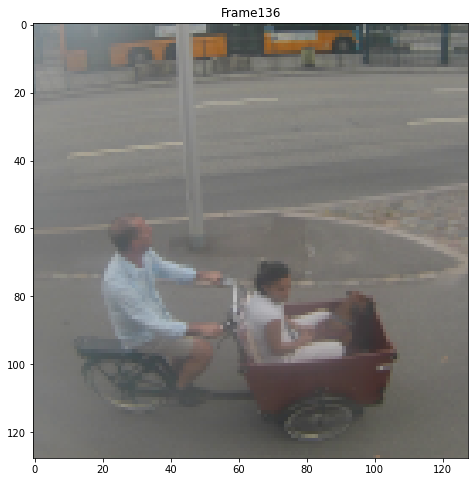

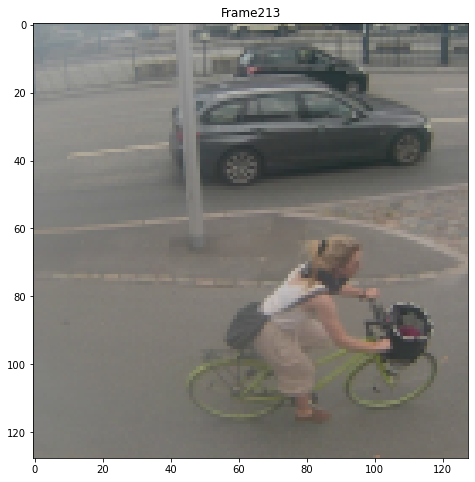

In [17]:
for i in (np.random.random(5)*pkl_annotation.shape[0]):
    visualizer.showFrameNumpy(pkl_annotation[int(i)], title = "Frame{}".format(int(i)))

All the frames were annotated manually with the categories, cyclist, helmet, hovding. It was a bounding box annotation method that was used and a total of 330 frames were annotated.

## 3. Results
This section contains the baseline results we got from the following models.

1. Pretrained YOLO3: Cyclist count \
As a baseline predictor. 

2. CNN (Helm-net): Cyclist count, Helmet count \
As a baseline predictor

3. Transfer learned YOLO3: Cyclist count, Helmet count
This model is the first improvement of the pretrained YOLO3 model and is only trained on the first 330 annotations.

### 3.1 Testing YOLO3 with pretrained weights as bike-prediction performance on annotated data
As we have now annotated some of our data it is possible to test how well the pretrained YOLO3 model can detect bikes. Our annotations are cyclists, helmets and hovding, however, the pretrained weights only include "Bike" and "Person" as relevant label this test is limited to predicting bikes. 

The output of the YOLO3 model gets converted into one of three classes. The classes corresponds to 0, if there are no bikes, 1 if there is 1 bike, 2 if there are 2 bikes or more. As the pretrained labels has both "bike" and "person" as labels, and our annotation of cyclist is essentially "bike+person", the conversion returns the maximum number of [bikes, person] as the prediction of number of bikes.

#### Predicting bounding boxes for annotated data
Using pretrained YOLO3 on the annotated data to test its performance. 

In [87]:
jpgpath = 'Annotations/JPG-To-Annotation/'
jpgfiles = [f for f in listdir(jpgpath) if isfile(join(jpgpath, f))]
jpgfiles.sort()
jpgfiles = jpgfiles

In [19]:
img_dic = {}

for idx, img in enumerate(pkl_annotation):
    ####### RETURN ########
    labels = predict_YOLO3_cphdata(img, model)
    img_dic[idx] = labels

#### Converting the annotated data into classes
The bounding box annotations are converted into classes such that we can assess classification performance. 

In [86]:
df_anno = pd.read_csv("Annotations/labels_deeplearning-copenhagen_2021-11-09-02-43-16.csv", \
names = ["Label", "x-coord", "y-coord", "width", "height", "ImageName", "Res_x", "Res_y"])

img_dic_anno = {}
unique_img = df_anno['ImageName'].unique()
imgs = jpgfiles

for img in imgs:
    if img in unique_img:
        img_dic_anno[img] = df_anno[df_anno['ImageName'] == img]['Label'].to_list()
    else:
        img_dic_anno[img] = []

cyclist_list = []

for list_ in img_dic_anno.values():
    n_cyclists = 0
    for pred in list_:
        if pred == "Cyclist":
            n_cyclists +=1
    if n_cyclists >= 2:
        n_cyclists = 2
    cyclist_list.append(n_cyclists)    

#### Calculation of confusion matrix
The bounding box annotations are converted into class predictions and visualized using a confusion matrix.

In [34]:
cyclists_list_pred = []
for val in img_dic.values():
    n_cyclist = 0
    n_person = 0
    for item in val:
        if (item == 'bicycle'):
            n_cyclist += 1
            if n_person >=2:
                n_person = 2
        elif (item == 'person'):
            n_person += 1
            if n_person >= 2:
                n_person = 2
    cyclists_list_pred.append(np.max([n_cyclist,n_person]))

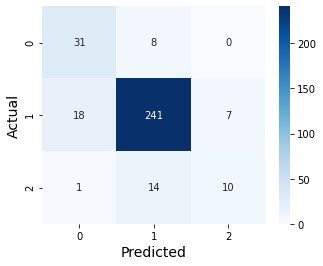

In [36]:
visualizer.plot_confusion_matrix(confusion_matrix(cyclist_list,cyclists_list_pred))

### 3.2 Pretrained YOLO3 on standard test-set
As both the CNN and the transfer learned YOLO3 used a large fraction of the annotated data to train only a small fraction could be used to best. To be able to compare YOLO3 pretrained with the CNN and transfer learned YOLO3 the pretrained YOLO3 was tested on the "test-set". 

In [85]:
#### The true data for the test set ####

cyclists_true = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1])

helm_true = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0])

#### The test_jpgs"
frames_test = reader.load_pickle("Annotations/FILE0020_annotated.pkl")

In [38]:
img_dic = {}

for idx, img in enumerate(frames_test):
    ####### RETURN ########
    labels = predict_YOLO3_cphdata(img, model)
    img_dic[idx] = labels

In [39]:
cyclists_list_pred = []
for val in img_dic.values():
    n_cyclist = 0
    n_person = 0
    for item in val:
        if (item == 'bicycle'):
            n_cyclist += 1
            if n_person >=2:
                n_person = 2
        elif (item == 'person'):
            n_person += 1
            if n_person >= 2:
                n_person = 2
    cyclists_list_pred.append(np.max([n_cyclist,n_person]))

Bike prediction


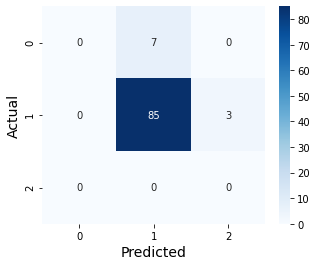

In [83]:
print("Bike prediction")
visualizer.plot_confusion_matrix(confusion_matrix(cyclists_true,cyclists_list_pred))

### 3.2 The CNN baseline model
This section contains the results we got from the CNN baseline model. As the CNN was trained on the DTU cluster only the results are shown in this notebook. The code and python scripts can be find on the GitHub.

Bike prediction


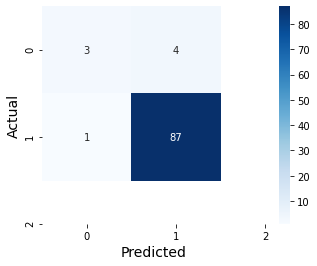

Helmet prediction


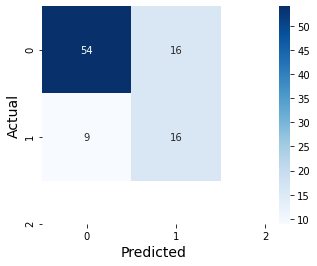

In [79]:
## Predictions from CNN trained on the first labelling session ##

cnn_pred_cyc = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1])

cnn_pred_helm = np.array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0])

print("Bike prediction")
visualizer.plot_confusion_matrix(confusion_matrix(cyclists_true,cnn_pred_cyc))
print("Helmet prediction")
visualizer.plot_confusion_matrix(confusion_matrix(helm_true,cnn_pred_helm))

### 3.3 The transfor learned YOLO3
In this section the results of the transfer learned YOLO3 model is presented. The results are generated on the DTU cluster and the code for this is in the Github. In the "keras-yolo3-master" folder there is a ReadMe file that explains how this is done in depth. 

Bike prediction


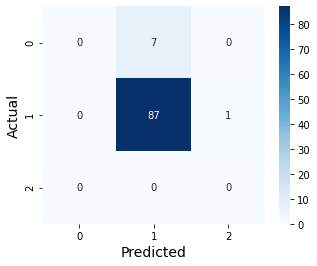

Helmet prediction


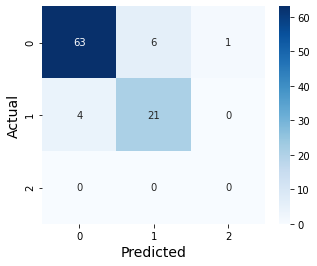

In [80]:
yolo3_preds_base = pd.read_csv("yolo3results/formated_preds_base.csv", index_col = 'Unnamed: 0')
yolo3_pred_bike = yolo3_preds_base.predBike.values
yolo3_pred_helm = yolo3_preds_base.predHelm.values + yolo3_preds_base.predHovd.values

print("Bike prediction")
visualizer.plot_confusion_matrix(confusion_matrix(cyclists_true,yolo3_pred_bike))
print("Helmet prediction")
visualizer.plot_confusion_matrix(confusion_matrix(helm_true,yolo3_pred_helm))

## 4. Exploring the potential of active learning and improving performance
This section contains the new results we got from improving the baseline results from above. The following things was done. 

    1. Annotations of more data based on active learning
    2. Additional traning of the models with more data
    

### 4.1 Active learning results and improvement of performance for CNN (Helm-net)
In this section active learning was tested for the CNN and the model was trained on an additional dataset. However, again tested on the separate test-set used above. 

#### 4.1.1 Active learning
The active learning was practically made by taking subset of a new labelled data set and look at the performance increase when training on additional random subsets or subsets that was selected using active learning described in the report. Here is a summary graph that has made using the code from Github (trained on the DTU cluster).

![alt text](Results_helmnet/helmnet-ac.png)


#### 4.1.2 Updated results
The below shows the results we got from the CNN after training it on the additional labelled data set. The performance does not really increase and the reasons for this is discussed in the report.

Bike prediction


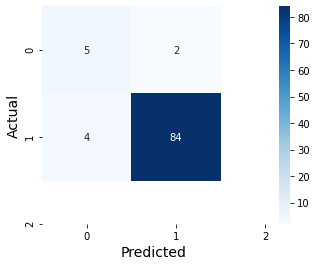

Helmet prediction


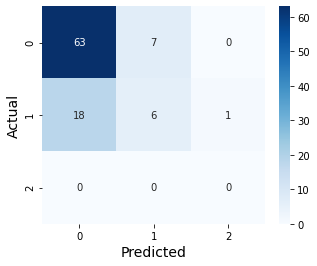

In [81]:
cnn_pred_cyc_final = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1])
cnn_pred_helm_final = np.array([0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0])

print("Bike prediction")
visualizer.plot_confusion_matrix(confusion_matrix(cyclists_true,cnn_pred_cyc_final))
print("Helmet prediction")
visualizer.plot_confusion_matrix(confusion_matrix(helm_true,cnn_pred_helm_final))

### 4.2 Active learning results and improvement of performance for transfer learned YOLOv3
As well as above it was also tested how YOLOv3 reacts on active learning and how the performance changes when given the additional labelled dataset.

#### 4.2.1 Active learning
The same as described above was done for YOLOv3 which gave the following results after training on the cluster.

![alt text](yolo3results/yolo3_ac_ma.png)
![alt text](yolo3results/yolo3_ac_acc.png)

It does in general for yolov3 seem that the active learning gives a bit better results for small subsets of the labels.


#### 4.2.2 Results 
The transfer learned YOLOv3 was provided with the full additional dataset which gave the results below.

Bike prediction


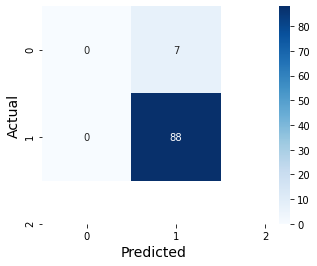

Helmet prediction


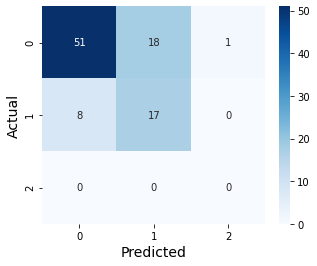

In [82]:
yolo3_preds_final = pd.read_csv("yolo3results/formated_preds_Retrained_all.csv", index_col = 'Unnamed: 0')
yolo3_pred_bike_final = yolo3_preds_final.predBike.values
yolo3_pred_helm_final = yolo3_preds_final.predHelm.values + yolo3_preds_final.predHovd.values

print("Bike prediction")
visualizer.plot_confusion_matrix(confusion_matrix(cyclists_true,yolo3_pred_bike_final))
print("Helmet prediction")
visualizer.plot_confusion_matrix(confusion_matrix(helm_true,yolo3_pred_helm_final))

In general it seems that the performance decreases. This is discussed in the report but can have something to do with the fact that it was sunshine on the new labelled dataset and thus, in general became harder to predict the data which has made significant changes in the weights.